# 1. Data Loading and Labeling

#### Load both CSV files into Pandas DataFrames.

In [1]:
# Import Library 
import pandas as pd

true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

#### Add a new column label
- 1 for real news (True.csv)
- 0 for fake news (Fake.csv)

In [2]:
true_df['label'] = 1
fake_df['label'] = 0

####  Combine both datasets into one and shuffle.

In [3]:
combined_df = pd.concat([true_df, fake_df], axis=0)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)  

combined_df.head()

,title,text,subject,date,label
0,THE VIEW’S Whoopi Goldberg To Co-Host: “This I...,https://youtu.be/RTuxvWjH3a4,politics,"Dec 1, 2016",0
1,PRESIDENT TRUMP TWEETS The Perfect New Years M...,"As 2017 comes to a close, we d like to acknowl...",politics,"Dec 31, 2017",0
2,Graft suspected in Indonesian anti-corruption ...,JAKARTA (Reuters) - An Indonesian prosecutor h...,worldnews,"November 9, 2017",1
3,"Christie Goes Ballistic On Cruz For ‘Awful, S...",Chris Christie went ballistic on Ted Cruz Wedn...,News,"July 21, 2016",0
4,"JIHAD FOR DUMMIES: How US Army Enlistee, Moham...",Note to little Johnny you might want to consid...,Government News,"Apr 10, 2015",0


# 2. Understand the Data

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


#### Checking for missing values

In [5]:
print("\nMissing values:\n", combined_df.isnull().sum())


Missing values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


#### `Observation` :  
- No missing values in the data

#### Checking for duplicates

In [6]:
combined_df.duplicated().sum()

209

#### `Observation` :  
- There are 209 duplicates presents in the data which are needed to remove.

In [7]:
combined_df.drop_duplicates(inplace = True)

In [8]:
combined_df.duplicated().sum()

0

#### `Observation` 
- Duplicates are removed.

#### Inspect a few rows of fake and true news.

In [9]:
print(combined_df[combined_df["label"] == 1].head())

                                                title  \
2   Graft suspected in Indonesian anti-corruption ...   
11  France suggests Hariri not free, urges he play...   
13  Sanders raises more cash but Clinton makes cam...   
14  House Republicans repeal Obamacare, hurdles aw...   
15  Trump talks to U.S. automakers, pushes for new...   

                                                 text       subject  \
2   JAKARTA (Reuters) - An Indonesian prosecutor h...     worldnews   
11  PARIS (Reuters) - France s foreign ministry on...     worldnews   
13  WASHINGTON/NEW YORK - Democratic presidential ...  politicsNews   
14  WASHINGTON (Reuters) - The U.S. House of Repre...  politicsNews   
15  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   

                  date  label  
2    November 9, 2017       1  
11  November 10, 2017       1  
13     April 21, 2016       1  
14        May 4, 2017       1  
15   January 24, 2017       1  


#### Review the distribution of labels.

In [10]:
combined_df["label"].value_counts()

label
0    23478
1    21211
Name: count, dtype: int64

#### `Observation` : 
- Here we can get the review that 0 (fake) news are 23478 and 1 (true) news are 21211

## 3. Data Cleaning & Preprocessing

In [11]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import warnings


warnings.filterwarnings('ignore')  # Ignore warnings

# Download required NLTK data
for pkg in ['stopwords', 'punkt', 'wordnet', 'omw-1.4']:
    nltk.download(pkg, quiet=True)

# Initialize resources
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(raw_text, flag='lemma'):

    # Step 1: Clean text (remove non-alphabets, lowercasing)
    sentence = re.sub("[^a-zA-Z]", " ", str(raw_text))
    sentence = sentence.lower()
    
    # Step 2: Tokenize
    tokens = sentence.split()
    
    # Step 3: Remove stopwords
    clean_tokens = [t for t in tokens if t not in stop_words]
    
    # Step 4: Stemming or Lemmatization
    if flag == 'stem':
        clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    # Step 5: Return joined text and token count
    return pd.Series([" ".join(clean_tokens), len(clean_tokens)])


combined_df['content'] = combined_df['title'].fillna('') + " " + combined_df['text'].fillna('')  # Combine title + text

combined_df[['clean_content', 'token_count']] = combined_df['content'].apply(lambda x: preprocess(x, flag='lemma'))  # Apply preprocessing

combined_df[['content', 'clean_content', 'token_count']].head()  # Preview

,content,clean_content,token_count
0,THE VIEW’S Whoopi Goldberg To Co-Host: “This I...,view whoopi goldberg co host black people wann...,15
1,PRESIDENT TRUMP TWEETS The Perfect New Years M...,president trump tweet perfect new year message...,961
2,Graft suspected in Indonesian anti-corruption ...,graft suspected indonesian anti corruption mon...,102
3,"Christie Goes Ballistic On Cruz For ‘Awful, S...",christie go ballistic cruz awful selfish speec...,207
4,"JIHAD FOR DUMMIES: How US Army Enlistee, Moham...",jihad dummy u army enlistee mohammed abdullah ...,451


#### `Observation` : 
- Here now our data is cleaned.
- This is our cleaned dataset

## 4. Exploratory Data Analysis (EDA)

In [12]:
# Imorting Necessary Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams

### Plot label distribution (Fake vs True)

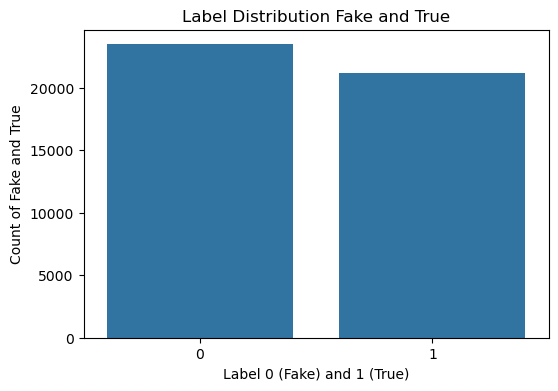

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x= "label", data = combined_df)
plt.title("Label Distribution Fake and True")
plt.xlabel("Label 0 (Fake) and 1 (True)")
plt.ylabel("Count of Fake and True")
plt.show()

#### `Observation` : 
- The number of fake news articles is slightly higher than the number of true news articles.
- This means the dataset is fairly balanced, but there are more fake samples than true ones.

### Word count distribution per class

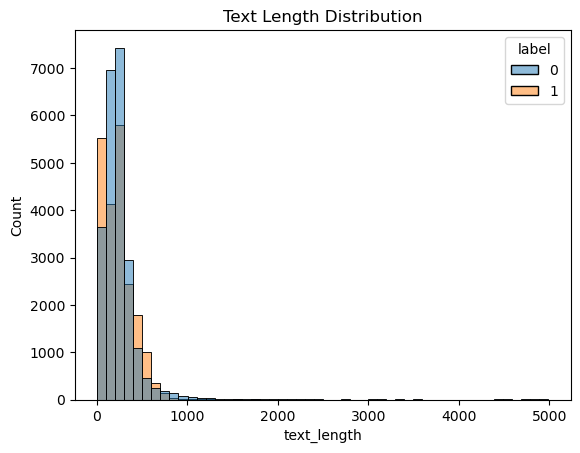

In [14]:
combined_df['text_length'] = combined_df['clean_content'].apply(lambda x: len(x.split()))
sns.histplot(data=combined_df, x='text_length', hue='label', bins=50)
plt.title("Text Length Distribution")
plt.show()

#### `Observation` :- 
- Fake news has a wider spread, with more long articles.
- True news is more consistent in length.
- So, fake news varies more in word count than true news.

###  Top 20 frequent words in fake vs real news

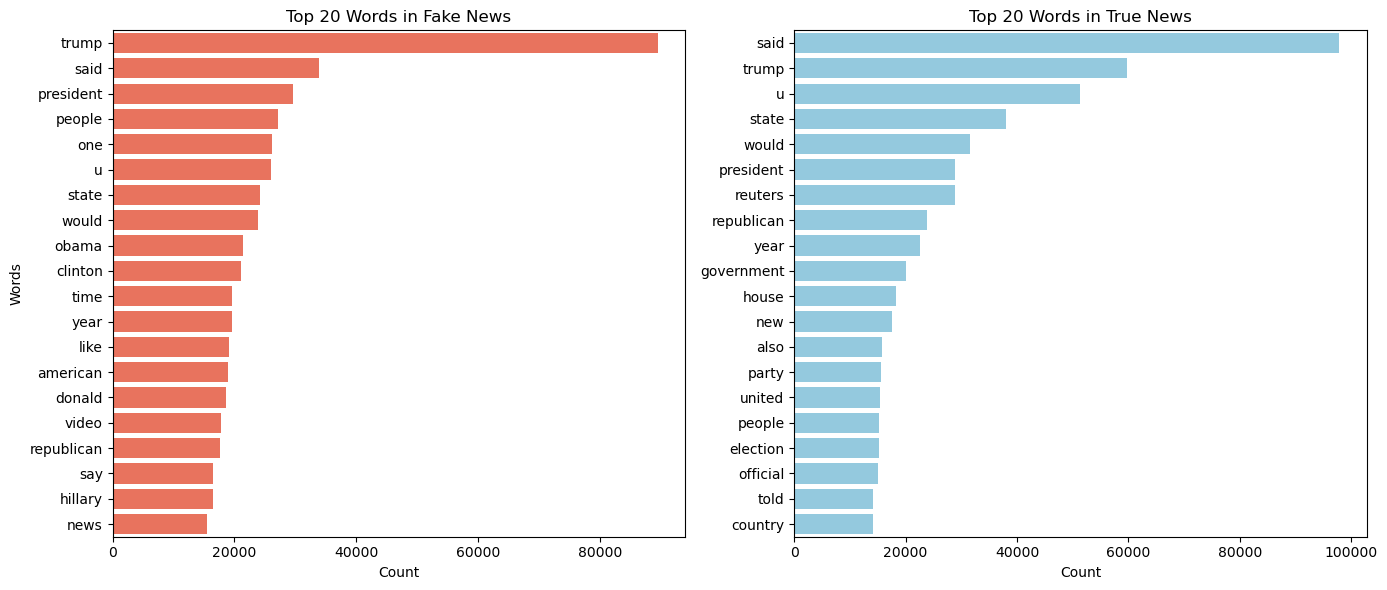

In [15]:
from collections import Counter


# Function to get top N words
def get_top_words(texts, n=20):
    words = " ".join(texts).split()
    freq = Counter(words)
    return pd.DataFrame(freq.most_common(n), columns=['Word', 'Count'])

# Get top words for Fake and True news
top_fake = get_top_words(combined_df[combined_df['label'] == 0]['clean_content'])
top_true = get_top_words(combined_df[combined_df['label'] == 1]['clean_content'])

# Create subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Fake News
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Word', data=top_fake, color='tomato')
plt.title("Top 20 Words in Fake News")
plt.xlabel("Count")
plt.ylabel("Words")

# Subplot 2: True News
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Word', data=top_true, color='skyblue')
plt.title("Top 20 Words in True News")
plt.xlabel("Count")
plt.ylabel("")

plt.tight_layout()
plt.show()


#### `Observation` :-
- Fake news uses more common and emotional words, while true news uses more topic-related and factual words. The graphs clearly show different word patterns between the two types of news.

### Word clouds

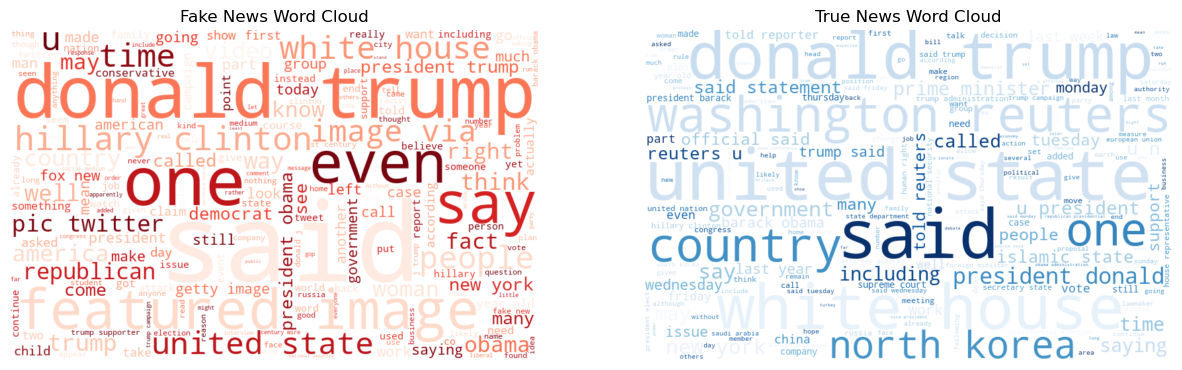

In [16]:
fake_text = " ".join(combined_df[combined_df['label']==0]['clean_content'])
true_text = " ".join(combined_df[combined_df['label']==1]['clean_content'])

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
wordcloud_fake = WordCloud(width=800, height=500, background_color='white', colormap='Reds').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")

plt.subplot(1,2,2)
wordcloud_true = WordCloud(width=800, height=500, background_color='white', colormap='Blues').generate(true_text)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title("True News Word Cloud")

plt.show()

## 5. Feature Extraction

#### Here for very first we need to split our data in to x and y

In [17]:
X = combined_df["clean_content"]
y = combined_df["label"]

In [18]:
X.head()

0    view whoopi goldberg co host black people wann...
1    president trump tweet perfect new year message...
2    graft suspected indonesian anti corruption mon...
3    christie go ballistic cruz awful selfish speec...
4    jihad dummy u army enlistee mohammed abdullah ...
Name: clean_content, dtype: object

In [19]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64

#### `Observation` :
- Here we have divided our data in to x as (clean_content) and y as (label)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [21]:
X_train.head()

7007     merkel scold ally shield coalition talk weedki...
5221     watch last week giant odell beckham jr peed fi...
40139           bill clinton space chew tongue rally video
24339    trump sold share company june spokesman washin...
42303    turkey detains islamic state suspect anadolu a...
Name: clean_content, dtype: object

In [22]:
X_test.head()

17927    trump university fine huge catch pay trump lat...
39649    u still hit climate goal despite supreme court...
36419    kremlin deeply concerned rising tension korean...
21812    guatemalan man dy falling waste grinder meat p...
7563     mugabe african leader ponder fate nairobi reut...
Name: clean_content, dtype: object

In [23]:
print(X_train.shape, X_test.shape)

(35751,) (8938,)


## TF-IDF

In [50]:
# Importing Necessary Libraries 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [58]:
vectorizer = TfidfVectorizer()

#### `Observation` :-
- So here in TF-IDF we use the fit transform on the X-train data for learning the data and to transform the data in numerical. And we also used the transform on the X-test to only transform the data to numerical.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### Fit_transform()

In [56]:
X_train_tf_idf = vectorizer.fit_transform(X_train)
X_train_tf_idf.shape

(35751, 98235)

### Transform()

In [57]:
X_test_tf_idf = vectorizer.transform(X_test)
X_test_tf_idf.shape

(8938, 98235)

#### `Observation` :
- Now here we have done with our fit transform and the transform
- fit() learns the vocabulary from your text — i.e., it figures out which words exist and how to score them.
- transform() converts each document into a vector using that learned vocabulary.
- fit_transform() does both in one step.

## 6. Model Creation

In [53]:
model = MultinomialNB()
model.fit(X_train_tf_idf, y_train)

MultinomialNB()

#### `Observation` :
- Here we have created our model of the multinomialNB

## 7. Model Evalution

In [54]:
y_pred = model.predict(X_test_tf_idf)

In [55]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

[[4385  230]
 [ 328 3995]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4615
           1       0.95      0.92      0.93      4323

    accuracy                           0.94      8938
   macro avg       0.94      0.94      0.94      8938
weighted avg       0.94      0.94      0.94      8938

Accuracy: 0.9375699261579772


#### `Observation` :
- Here we have evaluated our model i.e we had got the confusion matrix, classification report and the accuracy too

## Visualization for Confusion Matrix

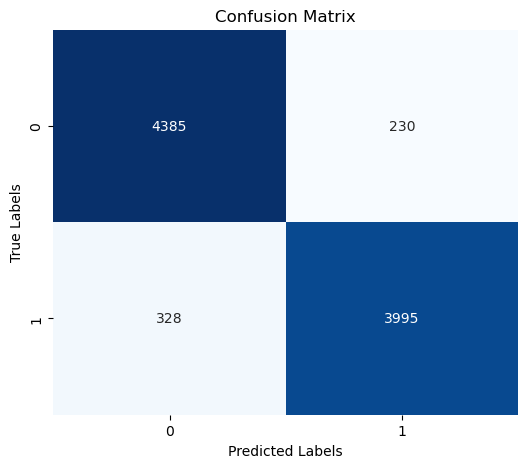

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Visualization for ROC

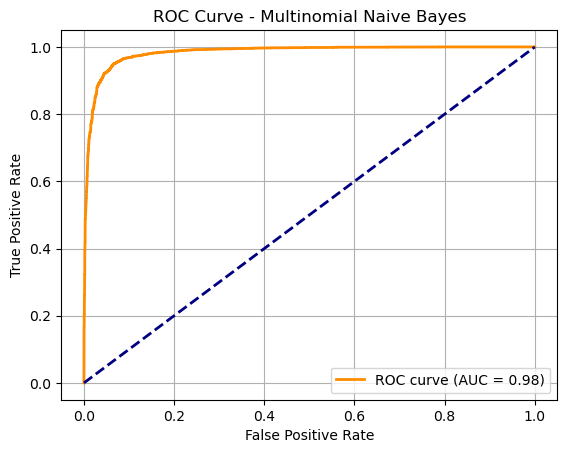

In [62]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test_tf_idf_transform)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 8. Error Analysis

### Print a few misclassified articles

In [63]:
errors = X_test[(y_pred != y_test)]
print("Total Misclassified Samples:", errors.shape[0])

Total Misclassified Samples: 558


### Analyze which fake articles were predicted as true (and vice versa)

In [64]:
wrong_indices = (y_pred != y_test)
wrong_df = X_test[wrong_indices]

print(wrong_df.head(10))

26945    among democrat another convention hum sander f...
20069    department justice fine sheriff excluding ille...
5384     hanson battler bus take anti immigrant road au...
12962    representative scalise condition upgraded seri...
672      haitian u malign trump decision send back home...
20248    trump hint pardon former arizona sheriff arpai...
1784     generation gap china one child generation grow...
21408    penny offended comment hamilton show washingto...
12588    new trump campaign manager push candidate focu...
30503    winning coal miner cheer president trump annou...
Name: clean_content, dtype: object


## 9. Insights

In [65]:
print(" Key Insights:")
print("1️ Model performs well in distinguishing between True and Fake news.")
print("2️ Fake news often has shorter sentences and more emotional words.")
print("3️ Clean preprocessing and TF-IDF improve performance.")
print("4️ Naive Bayes gives good baseline accuracy (~93%+ on many datasets).")

 Key Insights:
1️ Model performs well in distinguishing between True and Fake news.
2️ Fake news often has shorter sentences and more emotional words.
3️ Clean preprocessing and TF-IDF improve performance.
4️ Naive Bayes gives good baseline accuracy (~93%+ on many datasets).
